# loading Data

In [1]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [4]:
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [7]:
print("Number of images: {}".format(key_pts_frame.shape[0]))

Number of images: 3462


### show some images with the key points

In [8]:
def show_kpts(img, kpts):
    plt.imshow(img)
    plt.scatter(kpts[:, 0], kpts[:, 1], s=20, marker=".", color="m")

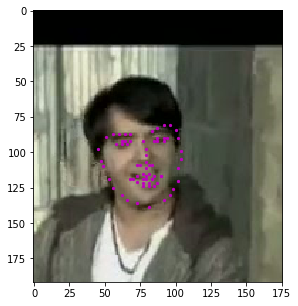

In [10]:
n = 0
img_name = key_pts_frame.iloc[n, 0]
kpts = key_pts_frame.iloc[n, 1:].values
kpts = kpts.astype("float32").reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_kpts(mpimg.imread(os.path.join('data/training/', image_name)), kpts)
plt.show()

### create dataset class for your data

In [20]:
import tensorflow as tf

def normalize(sample):
    image, key_pts = sample['image'], sample['keypoints']

    image_copy = np.copy(image)
    key_pts_copy = np.copy(key_pts)

    # convert image to grayscale
    image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # scale color range from [0, 255] to [0, 1]
    image_copy=  image_copy/255.0

    # scale keypoints to be centered around 0 with a range of [-1, 1]
    # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
    key_pts_copy = (key_pts_copy - 100)/50.0

    return {'image': image_copy, 'keypoints': key_pts_copy}


def rescale(sample, output_size):
    image, key_pts = sample['image'], sample['keypoints']

    h, w = image.shape[:2]
    if isinstance(output_size, int):
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h
    else:
        new_h, new_w = output_size

    new_h, new_w = int(new_h), int(new_w)

    img = cv2.resize(image, (new_w, new_h))

    # scale the pts, too
    key_pts = key_pts * [new_w / w, new_h / h]

    return {'image': img, 'keypoints': key_pts}


def randomCrop(sample, output_size):
    image, key_pts = sample['image'], sample['keypoints']

    h, w = image.shape[:2]
    new_h, new_w = output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top: top + new_h,
                  left: left + new_w]

    key_pts = key_pts - [left, top]

    return {'image': image, 'keypoints': key_pts}


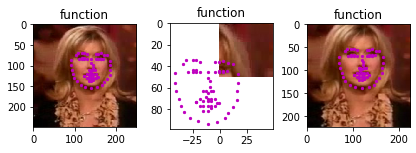

In [36]:
n = 500
img_name = key_pts_frame.iloc[n, 0]
kpts = key_pts_frame.iloc[n, 1:].values
kpts = kpts.astype("float32").reshape(-1, 2)
img = mpimg.imread(os.path.join('data/training/', img_name))
sample = {"image": img, "keypoints": kpts}

# transformed_sample = rescale(sample, (250, 250))
# transformed_sample = randomCrop(transformed_sample, (224, 224))
# transformed_sample['image'].shape

fig = plt.figure()
transformed_sample = rescale(sample, (250, 250))
ax = plt.subplot(1, 3, 1)
plt.tight_layout()
ax.set_title(type(tx).__name__)
show_kpts(transformed_sample['image'], transformed_sample['keypoints'])

transformed_sample = randomCrop(sample, (50, 50))
ax = plt.subplot(1, 3, 2)
plt.tight_layout()
ax.set_title(type(tx).__name__)
show_kpts(transformed_sample['image'], transformed_sample['keypoints'])

transformed_sample = rescale(sample, (250, 250))
transformed_sample = randomCrop(transformed_sample, (224, 224))
ax = plt.subplot(1, 3, 3)
plt.tight_layout()
ax.set_title(type(tx).__name__)
show_kpts(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [39]:
from tqdm import tqdm
X = []
y = []
for i in tqdm(range(len(key_pts_frame))):
    img_name = key_pts_frame.iloc[i, 0]
    kpts = key_pts_frame.iloc[i, 1:].values
    kpts = kpts.astype("float32").reshape(-1, 2)
    img = mpimg.imread(os.path.join('data/training/', img_name))
    sample = {"image": img, "keypoints": kpts}
    sample = rescale(sample, (250, 250))
    sample = randomCrop(sample, (224, 224))
    sample = normalize(sample)
    X.append(sample['image'])
    y.append(sample['keypoints'].reshape(-1, 1))

100%|██████████| 3462/3462 [03:27<00:00, 16.66it/s]


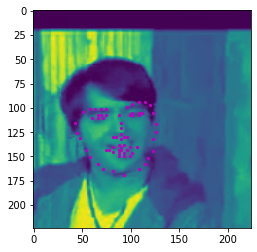

In [46]:
show_kpts(X[0], y[0].reshape(-1, 2) * 50 + 100)

In [47]:
np.save("data/images.npy", np.array(X))
np.save("data/landmarks.npy", np.array(y))

## Creating the model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout

In [51]:
model = Sequential([
    Conv2D(32, (5, 5), activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.2),
    
    Conv2D(32, (5, 5), activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(64, (5, 5), activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(128, (5, 5), activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Flatten(),
    
    Dense(2048, activation="relu"),
    BatchNormalization(),
    Dropout(0.5)
    
    Dense(1024, activation="relu"),
    BatchNormalization(),
    Dropout(0.5)
    
    Dense(136)
])